## Initialization

### Imports

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from tensorflow.python.keras.models import load_model
from wavetf._haar_conv import HaarWaveLayer2D, InvHaarWaveLayer2D

from attacks.gaussian_noise_attack import gaussian_noise_function
from attacks.rotation_attack import rotation_function
from attacks.salt_pepper_attack import salt_pepper_function
from attacks.stupid_attack import stupid_function
from data_loaders.attack_id_data_loader.tensor_flow_attack_id_data_loader import TensorFlowAttackIdDataLoader
from data_loaders.image_data_loaders.tensor_flow_image_data_loader import TensorFlowImageDataLoader
from data_loaders.watermark_data_loaders.tensor_flow_watermark_data_loader import TensorFlowWatermarkDataLoader

2022-07-23 14:35:47.023175: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### Configs

In [2]:
TEST_IMAGES_PATH = 'test_images/'
MODEL_PATH = 'pure_wavelet/'

SAMPLE_IMAGES_OUTPUT = 'sample_outputs/'

IMAGE_SIZE = (256, 256, 1)
WATERMARK_SIZE = (16 * 16,)
BATCH_SIZE = 10

ATTACKS = [
    'stupid_attack',
    'salt_pepper_attack',
    'gaussian_noise_attack',
    'rotation_attack'
]

## Preparations

### Prepare datasets

In [3]:
test_data_loaders = {}
for attack_id, attack in enumerate(ATTACKS):
    image_data_loader = TensorFlowImageDataLoader(
        base_path=TEST_IMAGES_PATH,
        channels=[0],
        convert_type=tf.float32
    ).get_data_loader()
    watermark_data_loader = TensorFlowWatermarkDataLoader(
        watermark_size=WATERMARK_SIZE
    ).get_data_loader()
    attack_id_data_loader = TensorFlowAttackIdDataLoader(
        min_value=attack_id,
        max_value=attack_id+1
    ).get_data_loader()
    
    input_data_loader = tf.data.Dataset.zip((
        image_data_loader,
        watermark_data_loader,
        attack_id_data_loader,
    ))
    input_data_loader = input_data_loader.batch(BATCH_SIZE)
    input_data_loader = input_data_loader.prefetch(1)
    test_data_loaders[attack] = input_data_loader

2022-07-23 14:35:55.427208: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-23 14:35:57.494832: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-23 14:35:57.494955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zenbook-ux533fn): /proc/driver/nvidia/version does not exist
2022-07-23 14:35:57.502783: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load model

#### Select model

In [18]:
def model_selector(model_path=MODEL_PATH):
    model_names_list = sorted(os.listdir(model_path))
    for idx, model_name in enumerate(model_names_list):
        print(idx, model_name)
    selected_idx = int(input('Model number: '))
    return model_names_list[selected_idx]

model_name = model_selector()
print(f'selected model is {model_name}')

0 epochs:001-embedded_image_loss:0.003707045-output_watermark_loss:0.171661437.hdf5
1 epochs:002-embedded_image_loss:0.001437914-output_watermark_loss:0.143709108.hdf5
2 epochs:003-embedded_image_loss:0.000957946-output_watermark_loss:0.133686990.hdf5
3 epochs:004-embedded_image_loss:0.000702425-output_watermark_loss:0.129191205.hdf5
4 epochs:005-embedded_image_loss:0.000548875-output_watermark_loss:0.133303821.hdf5
5 epochs:006-embedded_image_loss:0.000435240-output_watermark_loss:0.132980868.hdf5
6 epochs:007-embedded_image_loss:0.000366539-output_watermark_loss:0.125137404.hdf5
7 epochs:008-embedded_image_loss:0.000326768-output_watermark_loss:0.131531283.hdf5
8 epochs:009-embedded_image_loss:0.000299810-output_watermark_loss:0.128762677.hdf5
9 epochs:010-embedded_image_loss:0.000277588-output_watermark_loss:0.124729156.hdf5
10 epochs:011-embedded_image_loss:0.000259665-output_watermark_loss:0.120151870.hdf5
11 epochs:012-embedded_image_loss:0.000248334-output_watermark_loss:0.12185

Model number: 90
selected model is epochs:091-embedded_image_loss:0.000151333-output_watermark_loss:0.118467741.hdf5


#### Load model

In [19]:
model = load_model(
    MODEL_PATH + model_name, 
    custom_objects={
        'HaarWaveLayer2D': HaarWaveLayer2D, 
        'InvHaarWaveLayer2D': InvHaarWaveLayer2D,
        'tf': tf,
        'stupid_function': stupid_function,
        'salt_pepper_function': salt_pepper_function,
        'gaussian_noise_function': gaussian_noise_function,
        'rotation_function': rotation_function,
    }
)

/home/alireza/tapsi_hooni/env/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: models.wavetf_model is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '
/home/alireza/tapsi_hooni/env/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:6112: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  warnings.warn('`tf.keras.backend.random_binomial` is deprecated, '


## Evaluation

### Evaluation functions

In [20]:
def mse_cal(input_img, output_img):
    inp_cnv = np.array(input_img).reshape((256,256))
    out_cnv = np.array(output_img).reshape((256,256))
    return mean_squared_error(inp_cnv, out_cnv)


def psnr_cal(input_img, output_img, range_num):
    mse_num = mse_cal(input_img, output_img)
    return 10*math.log10((range_num**2)/mse_num)


def ber_cal(input_wm, output_wm):
    a = np.sum(np.equal(np.round(output_wm),input_wm))
    return 100-(100*a/256)


def evaluate_data(model, data_loader):
    psnr_list = []
    ber_list = []
    for x in data_loader:
        y = model.predict(x)
        for i in range(len(x[0])):
            psnr_list.append(psnr_cal(x[0][i], y[0][i], 1))
            ber_list.append(ber_cal(x[1][i], y[1][i]))
    return np.mean(psnr_list), np.mean(ber_list)

### Calculate attacks PSNR and BER

In [21]:
psnrs = {}
bers = {}

for attack in ATTACKS:
    print(f'{attack} started.')
    psnr, ber = evaluate_data(model, test_data_loaders[attack])
    psnrs[attack] = psnr
    bers[attack] = ber

stupid_attack started.
salt_pepper_attack started.
gaussian_noise_attack started.
rotation_attack started.


### Show stats

In [22]:
def show_table(psnrs, bers):
    table = [['attack', 'PSNR', 'BER']]
    for attack in ATTACKS:
        table.append([attack, psnrs[attack], bers[attack]])
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


show_table(psnrs, bers)

╒═══════════════════════╤═════════╤═══════════╕
│ attack                │    PSNR │       BER │
╞═══════════════════════╪═════════╪═══════════╡
│ stupid_attack         │ 39.1818 │  0.454688 │
├───────────────────────┼─────────┼───────────┤
│ salt_pepper_attack    │ 39.1818 │  7.36289  │
├───────────────────────┼─────────┼───────────┤
│ gaussian_noise_attack │ 39.1818 │ 10.343    │
├───────────────────────┼─────────┼───────────┤
│ rotation_attack       │ 39.1818 │ 49.966    │
╘═══════════════════════╧═════════╧═══════════╛


### Check some watermarked images

In [23]:
sample_output = None
for sample_input in test_data_loaders[ATTACKS[0]]:
    sample_output = model.predict(sample_input)
    break

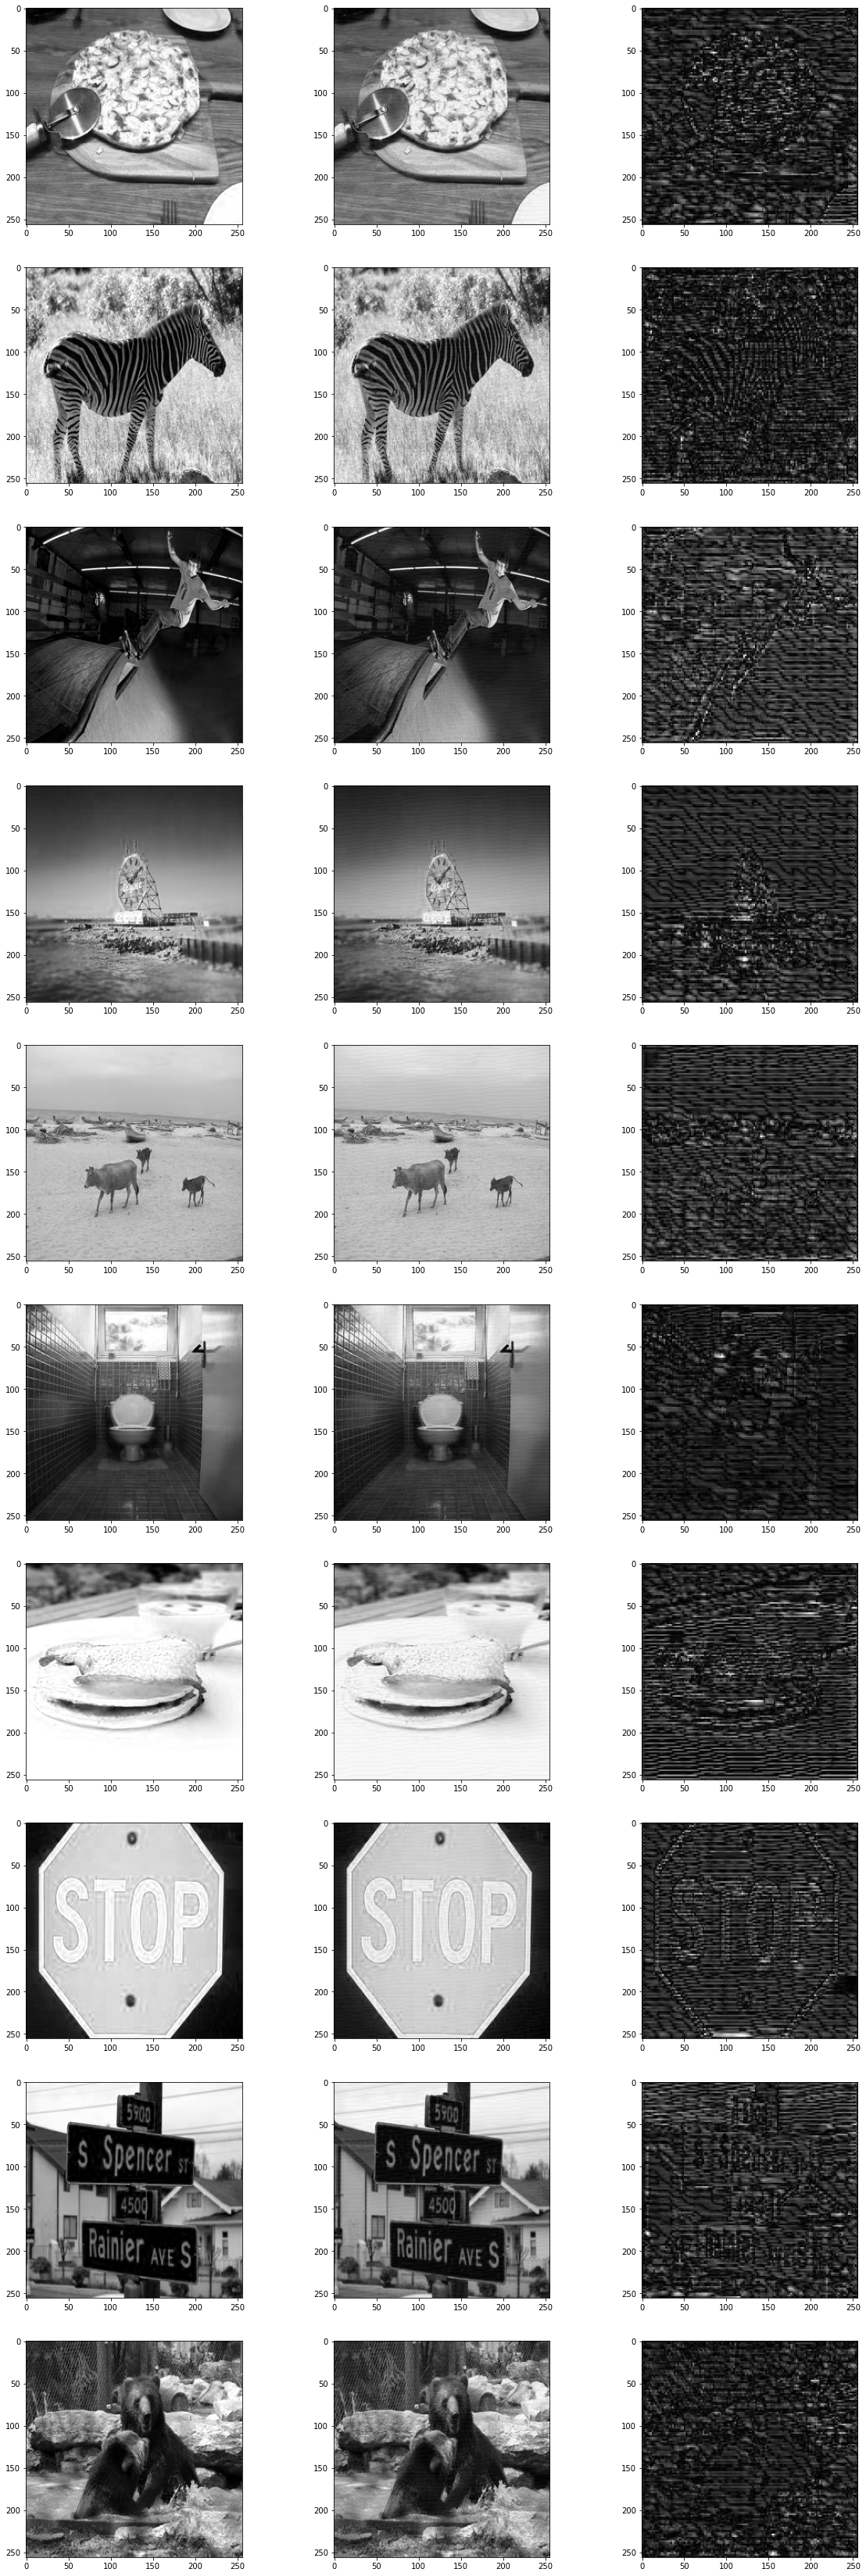

In [24]:
fig, axs = plt.subplots(BATCH_SIZE, 3, figsize=(20, 60))
for idx in range(BATCH_SIZE):
    axs[idx][0].imshow(sample_input[0][idx], cmap="gray")
    axs[idx][1].imshow(sample_output[0][idx], cmap="gray")
    axs[idx][2].imshow(abs(sample_input[0][idx] - sample_output[0][idx]), cmap="gray")

#### Salt & Pepper

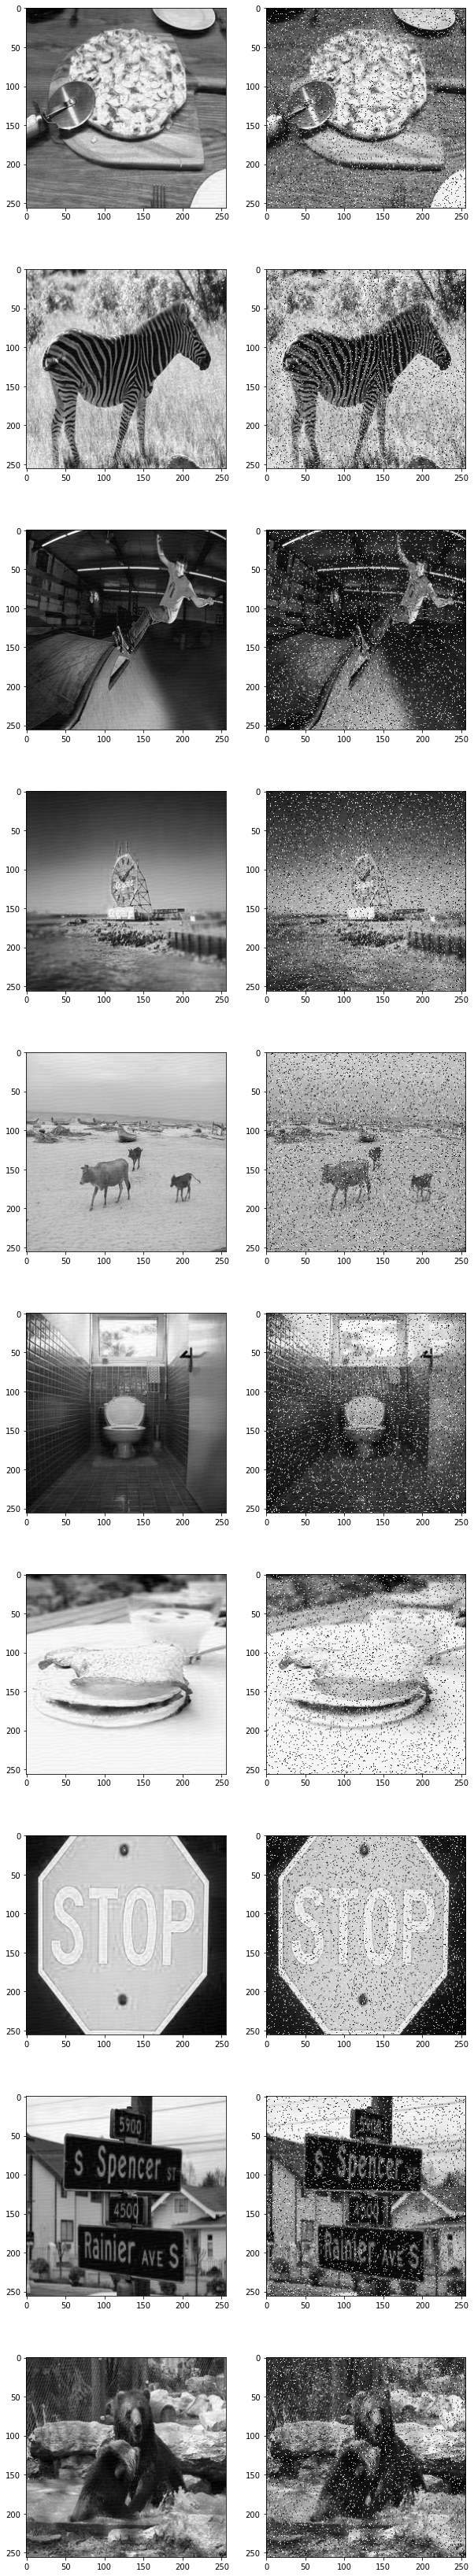

In [40]:
fig, axs = plt.subplots(BATCH_SIZE, 2, figsize=(10, 60))
for idx in range(BATCH_SIZE):
    axs[idx][0].imshow(sample_output[0][idx], cmap="gray")
    mask = np.random.binomial(n=1, p=.1, size=sample_output[0][idx].shape)
    noise = np.random.binomial(n=1, p=.5, size=sample_output[0][idx].shape)
    attacked_sample = sample_output[0][idx] * (1 - mask) + noise * mask
    axs[idx][1].imshow(attacked_sample, cmap="gray")

#### Gaussian noise

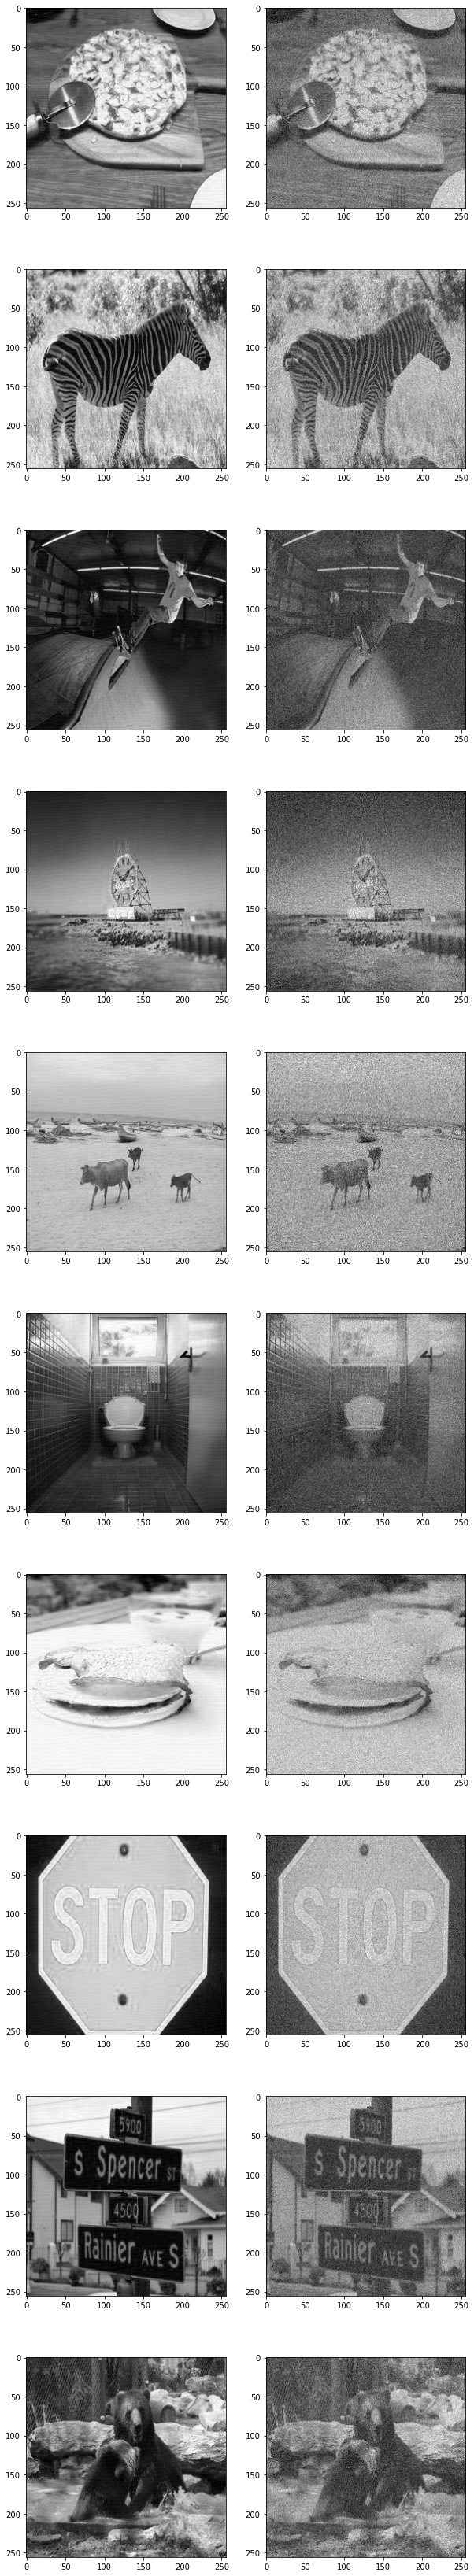

In [34]:
fig, axs = plt.subplots(BATCH_SIZE, 2, figsize=(10, 60))
for idx in range(BATCH_SIZE):
    axs[idx][0].imshow(sample_output[0][idx], cmap="gray")
    noise = np.random.normal(loc=0.0, scale=.1, size=sample_output[0][idx].shape)
    attacked_sample = sample_output[0][idx] + noise
    axs[idx][1].imshow(attacked_sample, cmap="gray")

### Save samples

In [41]:
for idx in range(BATCH_SIZE):
    input_filename = f'input_{idx}.png'
    output_filename = f'output_{idx}.png'
    salt_pepper_filename = f'salt_pepper_{idx}.png'
    gaussian_filename = f'gaussian_{idx}.png'
    diff_filename = f'diff_{idx}.png'
    
    input_image = np.repeat(sample_input[0][idx].numpy(), 3, axis=2) * 256
    output_image = np.repeat(sample_output[0][idx], 3, axis=2) * 256
    
    salt_pepper_mask = np.random.binomial(n=1, p=.1, size=sample_output[0][idx].shape)
    salt_pepper_noise = np.random.binomial(n=1, p=.5, size=sample_output[0][idx].shape)
    salt_pepper_image = np.repeat(
        sample_output[0][idx] * (1 - salt_pepper_mask) + salt_pepper_noise * salt_pepper_mask,
        3, axis=2) * 256
    
    gaussian_noise = np.random.normal(loc=0.0, scale=.1, size=sample_output[0][idx].shape)
    gaussian_image = np.repeat(sample_output[0][idx] + gaussian_noise, 3, axis=2) * 256
    
    diff_image = np.repeat(
        abs(sample_input[0][idx] - sample_output[0][idx]), 3, axis=2) * 256
    
    cv2.imwrite(os.path.join(SAMPLE_IMAGES_OUTPUT, input_filename), input_image)
    cv2.imwrite(os.path.join(SAMPLE_IMAGES_OUTPUT, output_filename), output_image)
    cv2.imwrite(os.path.join(SAMPLE_IMAGES_OUTPUT, salt_pepper_filename), salt_pepper_image)
    cv2.imwrite(os.path.join(SAMPLE_IMAGES_OUTPUT, gaussian_filename), gaussian_image)
    cv2.imwrite(os.path.join(SAMPLE_IMAGES_OUTPUT, diff_filename), diff_image)